# DNN

## Setup

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

%load_ext tensorboard

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

In [2]:
K = keras.backend

In [3]:
# Common imports
import math
import os

import numpy as np
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt

from sklearn.base import clone
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV

import pickle

import seaborn as sns; sns.set()

In [4]:
import utils

In [5]:
root_logdir = os.path.join(os.curdir, "logs")

def get_run_logdir(postfix=None):
    import time
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    if postfix is not None:
        run_id = run_id + '_' + postfix
    return os.path.join(root_logdir, run_id)

run_logdir = get_run_logdir()
run_logdir

'./logs/run_2020_05_06-17_46_15'

In [6]:
# to make this notebook's output stable across runs
RSEED = 42

np.random.seed(RSEED)
tf.random.set_seed(RSEED)

## Data

In [7]:
# Importing the dataset
df, df_avg = utils.load_sensors_data()
df_avg.head()

,people,co2,hum_avg,temp_avg,light_avg
120,0.0,394.0,46.16000,30.10900,0.0
121,0.0,394.0,46.20775,30.12425,0.0
122,0.0,394.0,46.18525,30.13775,0.0
123,0.0,394.0,46.18750,30.13775,0.0
124,0.0,395.0,46.19325,30.13750,0.0


In [8]:
# Assigning the input and output values
X_root = df.iloc[:, 2:]
y_root = df.iloc[:, 1]
X_avg = df_avg.iloc[:, 1:]

X_avg.head()

,co2,hum_avg,temp_avg,light_avg
120,394.0,46.16000,30.10900,0.0
121,394.0,46.20775,30.12425,0.0
122,394.0,46.18525,30.13775,0.0
123,394.0,46.18750,30.13775,0.0
124,395.0,46.19325,30.13750,0.0


In [9]:
from sklearn.model_selection import train_test_split


X_avg_train_val, X_avg_test, y_avg_train_val, y_avg_test = train_test_split(
    X_avg, y_root, test_size=0.3, random_state=RSEED)
X_avg_train, X_avg_val, y_avg_train, y_avg_val = train_test_split(
    X_avg_train_val, y_avg_train_val, test_size=0.2, random_state=RSEED)

X_root_train_val, X_root_test, y_root_train_val, y_root_test = train_test_split(
    X_root, y_root, test_size=0.3, random_state=RSEED)
X_root_train, X_root_val, y_root_train, y_root_val = train_test_split(
    X_root_train_val, y_root_train_val, test_size=0.2, random_state=RSEED)

In [10]:
std_scaler_X_avg = StandardScaler()
std_scaler_X_avg.fit(X_avg_train_val)

X_avg_train_val_scaled = std_scaler_X_avg.transform(X_avg_train_val)
X_avg_train_scaled = std_scaler_X_avg.transform(X_avg_train)
X_avg_val_scaled = std_scaler_X_avg.transform(X_avg_val)
X_avg_test_scaled = std_scaler_X_avg.transform(X_avg_test)

std_scaler_X = StandardScaler()
std_scaler_X.fit(X_root_train_val)

X_root_train_val_scaled = std_scaler_X.transform(X_root_train_val)
X_root_train_scaled = std_scaler_X.transform(X_root_train)
X_root_val_scaled = std_scaler_X.transform(X_root_val)
X_root_test_scaled = std_scaler_X.transform(X_root_test)

X_avg_train_val_scaled

array([[ 0.09991889,  0.61703517,  1.02739192, -1.57390866],
       [ 0.86562882,  0.56737213, -0.25703667,  0.42482764],
       [-0.23894849,  0.48846928, -0.83632442,  0.80081746],
       ...,
       [ 0.81675371,  0.62588895, -0.7218299 ,  0.88286009],
       [ 1.13932939, -1.13318699, -0.41196775,  0.77802369],
       [-1.26206729,  1.8633356 , -0.14890296, -1.57390866]])

## Model

### SNN with Nadam optimizer

In [ ]:
n_neurons = 100

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=(4,)),
    keras.layers.Dense(n_neurons, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(n_neurons, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(n_neurons, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(n_neurons, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(n_neurons, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(n_neurons, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(n_neurons, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(1)
])

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=(4,)),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(1)
])

optimizer = keras.optimizers.Nadam(lr=0.001, beta_1=0.9, beta_2=0.999)
model.compile(loss="mean_squared_error", optimizer=optimizer, metrics=[
              "mae"])
# model.compile(loss="mean_squared_error", optimizer='nadam', metrics=[
#               "mae"])

model.summary()

In [ ]:
# early_stopping_cb = keras.callbacks.EarlyStopping(
#     patience=40, restore_best_weights=True)
checkpoint_cb = keras.callbacks.ModelCheckpoint(
    "people_model_nadam.h5", save_best_only=True)
tensorboard_cb = keras.callbacks.TensorBoard(get_run_logdir('nadam'))

n_epochs = 1500
history = model.fit(X_avg_train_val_scaled, y_avg_train_val, epochs=n_epochs,
                    validation_data=(X_avg_val_scaled, y_avg_val), callbacks=[checkpoint_cb, tensorboard_cb])


In [ ]:
with open('people_model_nadam_history.pkl', 'wb') as pickle_file:
    pickle_file.write(pickle.dumps(history.history))

### SNN with OneCycleScheduler (skipped)

In [ ]:
class ExponentialLearningRate(keras.callbacks.Callback):
    def __init__(self, factor):
        self.factor = factor
        self.rates = []
        self.losses = []
    def on_batch_end(self, batch, logs):
        self.rates.append(K.get_value(self.model.optimizer.lr))
        self.losses.append(logs["loss"])
        K.set_value(self.model.optimizer.lr, self.model.optimizer.lr * self.factor)

def find_learning_rate(model, X, y, epochs=1, batch_size=32, min_rate=10**-5, max_rate=10):
    init_weights = model.get_weights()
    iterations = len(X) // batch_size * epochs
    factor = np.exp(np.log(max_rate / min_rate) / iterations)
    init_lr = K.get_value(model.optimizer.lr)
    K.set_value(model.optimizer.lr, min_rate)
    exp_lr = ExponentialLearningRate(factor)
    history = model.fit(X, y, epochs=epochs, batch_size=batch_size,
                        callbacks=[exp_lr])
    K.set_value(model.optimizer.lr, init_lr)
    model.set_weights(init_weights)
    return exp_lr.rates, exp_lr.losses

def plot_lr_vs_loss(rates, losses):
    plt.plot(rates, losses)
    plt.gca().set_xscale('log')
    plt.hlines(min(losses), min(rates), max(rates))
    plt.axis([min(rates), max(rates), min(losses), (losses[0] + min(losses)) / 2])
    plt.xlabel("Learning rate")
    plt.ylabel("Loss")

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=(4,)),
    keras.layers.Dense(100, activation="selu",
                       kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu",
                       kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu",
                       kernel_initializer="lecun_normal"),
    keras.layers.Dense(1)
])

model.compile(loss="mean_squared_error",
              optimizer=keras.optimizers.SGD(lr=1e-3),
              metrics=["mae"])

batch_size = 128
rates, losses = find_learning_rate(model, X_avg_train_val_scaled, y_avg_train_val, epochs=1, batch_size=batch_size)
plot_lr_vs_loss(rates, losses)
rates[np.argmin(losses)]

In [ ]:
class OneCycleScheduler(keras.callbacks.Callback):
    def __init__(self, iterations, max_rate, start_rate=None,
                 last_iterations=None, last_rate=None):
        self.iterations = iterations
        self.max_rate = max_rate
        self.start_rate = start_rate or max_rate / 10
        self.last_iterations = last_iterations or iterations // 10 + 1
        self.half_iteration = (iterations - self.last_iterations) // 2
        self.last_rate = last_rate or self.start_rate / 1000
        self.iteration = 0

    def _interpolate(self, iter1, iter2, rate1, rate2):
        return ((rate2 - rate1) * (self.iteration - iter1)
                / (iter2 - iter1) + rate1)

    def on_batch_begin(self, batch, logs):
        if self.iteration < self.half_iteration:
            rate = self._interpolate(
                0, self.half_iteration, self.start_rate, self.max_rate)
        elif self.iteration < 2 * self.half_iteration:
            rate = self._interpolate(self.half_iteration, 2 * self.half_iteration,
                                     self.max_rate, self.start_rate)
        else:
            rate = self._interpolate(2 * self.half_iteration, self.iterations,
                                     self.start_rate, self.last_rate)
            rate = max(rate, self.last_rate)
        self.iteration += 1
        K.set_value(self.model.optimizer.lr, rate)


model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=(4,)),
    keras.layers.Dense(100, activation="selu",
                       kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu",
                       kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu",
                       kernel_initializer="lecun_normal"),
    keras.layers.Dense(1)
])

model.compile(loss="mean_squared_error", optimizer=keras.optimizers.SGD(lr=0.001), metrics=[
              "mae"])

early_stopping_cb = keras.callbacks.EarlyStopping(
    patience=40, restore_best_weights=True)
checkpoint_cb = keras.callbacks.ModelCheckpoint(
    "people_model_1cycle.h5", save_best_only=True)
tensorboard_cb = keras.callbacks.TensorBoard(get_run_logdir('1cycle'))


batch_size = 128
# batch_size = 32
n_epochs = 500
onecycle = OneCycleScheduler(len(X_avg_train_val_scaled) //
                             batch_size * n_epochs, max_rate=0.05, start_rate=0.005)

history = model.fit(X_avg_train_val_scaled, y_avg_train_val, epochs=n_epochs,
                    validation_data=(X_avg_val_scaled, y_avg_val), callbacks=[onecycle, checkpoint_cb, tensorboard_cb])

### Model Performance

2627/2627 [==============================] - 0s 52us/sample - loss: 1.7789 - mae: 0.8408
Saving figure ann_learning_curve


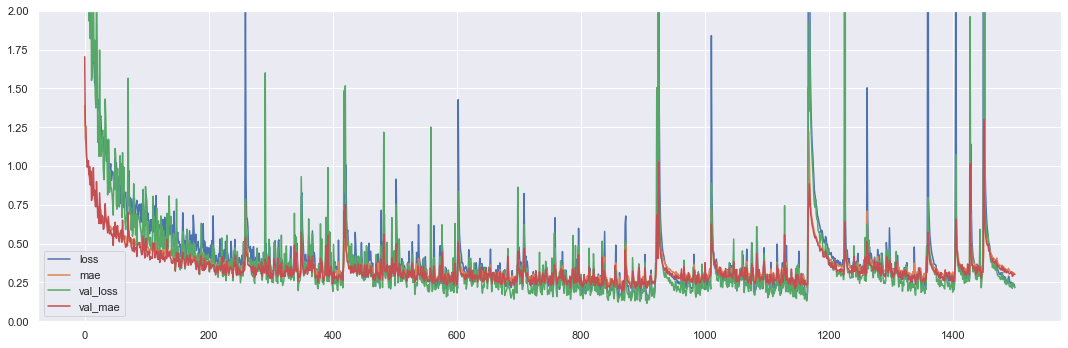

In [11]:
model = keras.models.load_model("people_model_nadam.h5")
with open('people_model_nadam_history.pkl', 'rb') as pickle_file:
    history = pickle.load(pickle_file)

mse_test = model.evaluate(X_avg_test_scaled, y_avg_test)
pd.DataFrame(history).plot(figsize=(15, 5))
plt.gca().set_ylim(0, 2)
# plt.grid(True)
utils.save_fig('ann_learning_curve')
plt.show()

In [12]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 4)                 0         
_________________________________________________________________
dense_8 (Dense)              (None, 100)               500       
_________________________________________________________________
dense_9 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_10 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_11 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_12 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_13 (Dense)             (None, 100)              

Training RMSE : 1.2757388978462931
Training MAE : 0.8102644096025736
Training Explained Variance : 0.8673120752834241
Testing RMSE : 1.333739650123476
Testing MAE : 0.8408380487503369
Testing Explained Variance : 0.8596876894827755
Saving figure ANN_pred_actual_instance_train


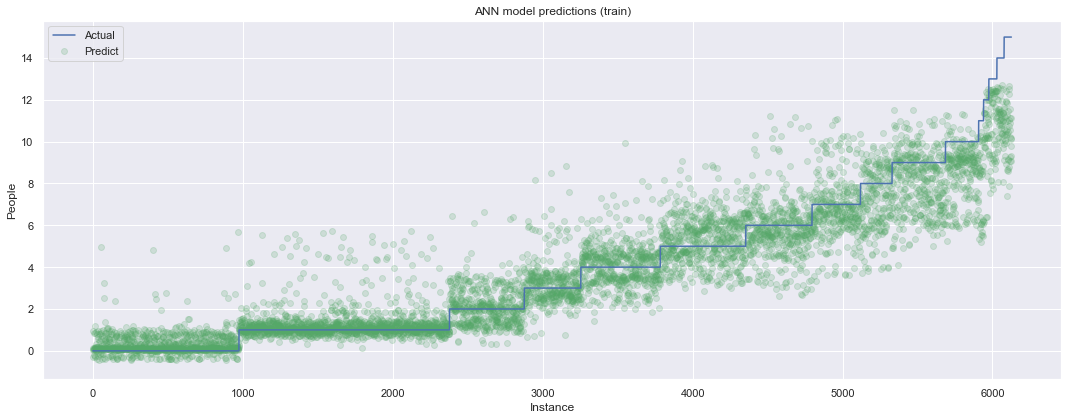

Saving figure ANN_pred_actual_instance_test


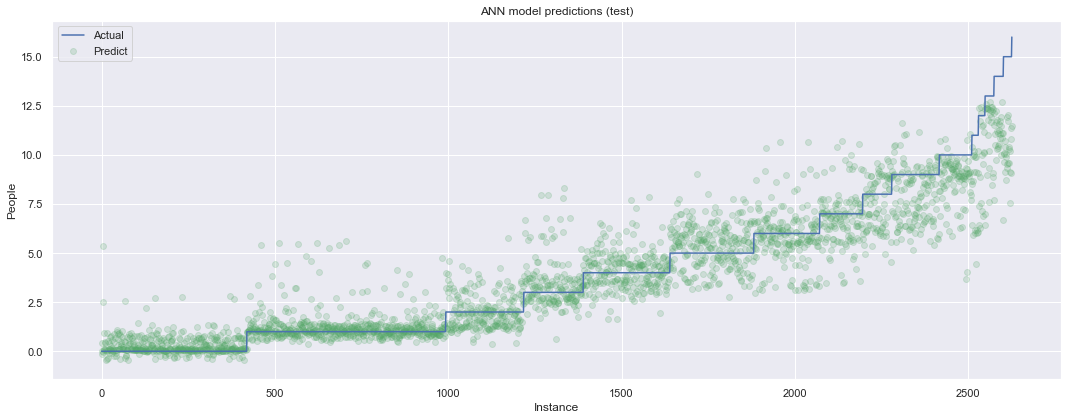

Saving figure ANN_pred_actual_reduced_train


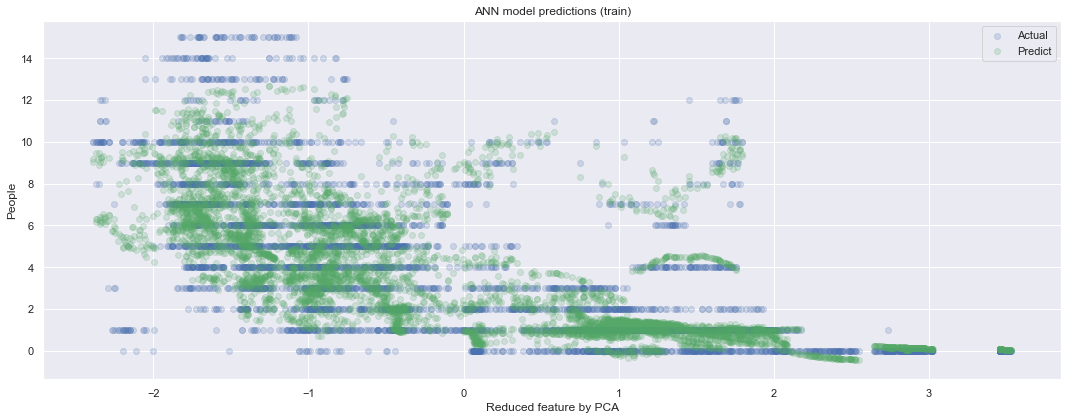

Saving figure ANN_pred_actual_reduced_test


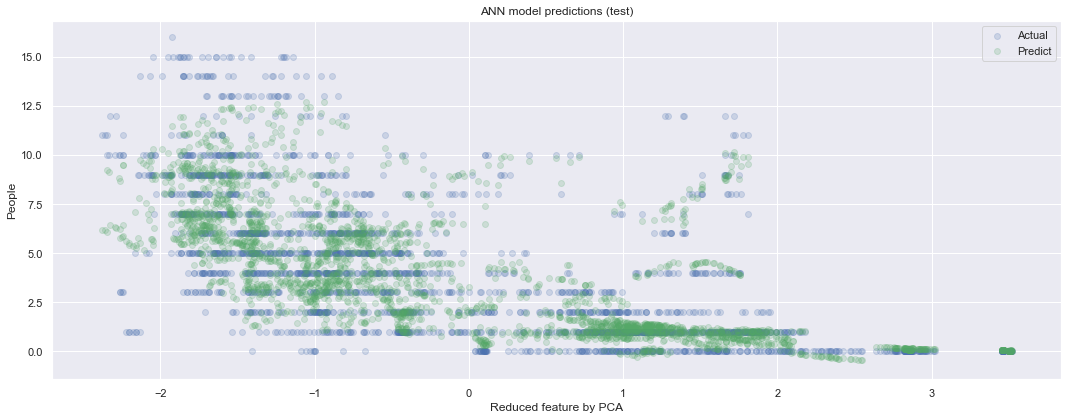

In [13]:
pca = PCA(n_components=1)
pca.fit(X_avg_train_val_scaled)

utils.plot_prediction_wtih_pca(model, pca, X_avg_train_val_scaled, X_avg_test_scaled, y_avg_train_val, y_avg_test, name='ANN')